# A Random Project: Taking a Look at Windows PRNG

The internal workings of RNG have always amazed me; how mathematicians can come up with models to create backtrack safe RNG is still a mystery to me even after this project. A question I asked myself at the beginning of the year is how do different PRNG run on Windows. Would it be possible to figure out the best to use in terms of number security and runtime? The answer is both yes and no. Let me explain.

## How does PRNG work?
This is specific to ```CryptGenRandom()``` but is still representative of the process as a whole
![PRNG Flowchart](img/test.png "Figure 1")

Source: Howard 2004

## Entropy Pools in Win10

- Each entropy pool is implemented as a ```SHA-512``` computation; all data provided to the entropy pool is appended, and when the pool is accessed, the ```SHA-512``` of all the data is used as the output of the pool.	
- There can be multiple entropy pools. When there are $N$ pools, entropy events are distributed in round robin format over those $N$ pools. This ensures roughly equal entropy inflow at all times.	
- The $N$ pools are numbered $(0,N-1)$. Pool 0 is used on every reseed. Pool 1 is used (in addition to pool 0) every 3rd reseed, pool 2 is used every 9th reseed (in addition to pools 0 and 1), etc. 
- In general, pool $K$ is used every $3^K$ reseed (in addition to all the lower numbered pools). Only one entropy pool exists at startup, the next are only opened up with the reseed interval reaches its max. 
- High-pull entropy sources split their 64 bytes between pools $(0,N-1)$
- Pool 0 receives the *first* 32 bytes of data, the rest is distributed via the round robin format.

Source: Ferguson 2019


## The Physics
- The general concept behind a PRNG is to take some generated bits from the entropy pool and output them to the running program.
- As more and more numbers are generated, the smaller the entropy pool becomes,  which can lead to longer runtimes.
- Our goal here is to determine the rate at which entropy pool depletion impacts various PRNG on Windows, if at all.
- Our runtimes can be modeled as a linear regression, $\hat{y} = mx + b$, where $m$ is our rate of change in runtime due to the entropy pool interference.
- **NOTE: The runtimes will not be 100% accurate as there will be random fluctuations due to factors such as natural CPU execution time jitter, other running programs, running internal OS operations, etc.**


## The Plan

In order to analyze the data our PRNG returned, we can firstly take a look at how the runtimes map over time, as well as the entropy of the number set produced. By calculating rate of change of change for the runtimes, we can approximate the impact that entropy pool depletion has on the PRNG runtimes. We could obviously extend this further to implement various statistical methods like $\chi^2$ to check how random in fact our numbers are, but for simplicity's sake, we're using Shannon Entropy to describe the information density of our set of random numbers. To actually create a model for the pool size's impact, we used numpy's polyfit tool which gives us back the slope and intercept of the best fit line to the $n^{\text{th}}$ degree. Essentially, this creates a linear regression for us by giving us the $m$ and $b$ of our regression $\hat{y} = mx + b$.

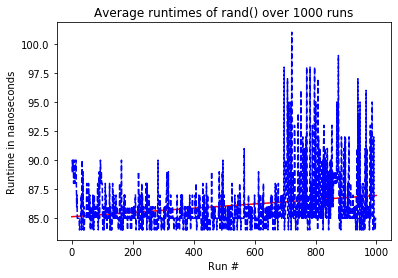

In [67]:
#@author Christian Krenzlin

#import all our data and plotting tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import entropy





"""Section for rand()"""

reg_rand_data = np.loadtxt("singles_average_rand.txt")
reg_values = np.loadtxt("rand_all_values.txt")
total_avg_rand = np.average(reg_rand_data);

sr = pd.Series(reg_values)
ct = sr.value_counts()
e_rand = entropy(ct)

x = np.arange(len(reg_rand_data))
y = reg_rand_data

slope, intercept = np.polyfit(x, y, 1)
#print(slope,intercept)

slope_data = (x * slope) + intercept
plt.plot(x, slope_data, "-r", label="Best fit")
plt.plot(x,y,"b--", label='rand()')
plt.xlabel("Run #")
plt.ylabel("Runtime in nanoseconds")
plt.title("Average runtimes of rand() over 1000 runs")
plt.show()
#print("Shannon entropy for rand():", e)

In [68]:
print("Shannon entropy for rand():", e_rand)
print("\tTime per unit entropy:", (total_avg_rand / e_rand), "ns")
print("Model: y = " + str(slope) + "x + " + str(intercept))

Shannon entropy for rand(): 10.395574364140842
	Time per unit entropy: 8.277464715833588 ns
Model: y = 0.0018300798300798543x + 85.13487512487512


## rand() 
The C function ```rand()``` is not FIPS approved, meaing it is not cryptographically secure, and is especially vulnerable when used with the ```%``` operator. This is due to the fact that the modulus operator creates a non-uniform distribution (Lavavey 2013). Since we aren't creating these numbers for a secure purpose, there would be no real harm in including the modulus operator as it is a $O(1)$ operation. The limit set in my code is ```RAND_MAX```, which the same as the size of ```rand()```'s distribution, therefore not creating the non-uniformity issue.

C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


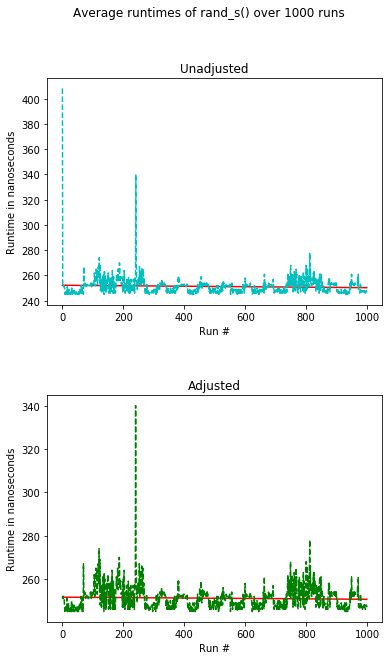

In [69]:
"""Section for rand_s()"""
fig, (orig,adj) = plt.subplots(2, gridspec_kw={'hspace':0.4})
fig.suptitle("Average runtimes of rand_s() over 1000 runs")
fig.set_figheight(10)

sec_rand_data = np.loadtxt("singles_average_rand_s.txt")
sec_values = np.loadtxt("rand_s_all_values.txt")
total_avg_rand_s = np.average(sec_rand_data)

sr = pd.Series(sec_values)
ct = sr.value_counts()
e_rands = entropy(ct)

x = np.arange(len(sec_rand_data))
y = sec_rand_data

orig_slope, orig_intercept = np.polyfit(x, y, 1)
#print(slope,intercept)

slope_data = (x * orig_slope) + orig_intercept
orig.plot(x, slope_data, "-r", label="Best fit")

orig.plot(x,y, "c--", label='rand_s()')
orig.set_title("Unadjusted")
orig.set_xlabel("Run #")
orig.set_ylabel("Runtime in nanoseconds")

#As one can see from the graphs, rand_s() has a huge initial time cost,
#greater overall time cost, but also higher entropy

#adjusted graph to remove the initial startup value
n = np.delete(sec_rand_data, 0, None)
x = np.arange(len(n))
adj_slope, adj_intercept = np.polyfit(x, n, 1)

n_total_avg_rand_s = np.average(n)

slope_data = (x * adj_slope) + adj_intercept
adj.plot(x, slope_data, "-r", label="Best fit")
adj.plot(x,n,"g--", label='adjusted rand_s()')
adj.set_title("Adjusted")
adj.set_xlabel("Run #")
adj.set_ylabel("Runtime in nanoseconds")
fig.show()

As one can see from the graphs, ```rand_s()``` has a huge initial time cost, and greater overall time cost per call.

In [70]:
#print the entropy values
print("Shannon entropy for unadjusted rand_s():", e_rands)
print("\tTime per unit entropy:", (total_avg_rand_s / e_rands), "ns")
print("\tModel: y = " + str(orig_slope) + "x + " + str(orig_intercept))
print("Shannon entropy for adjusted rand_s():", n_e_rands)
print("\tTime per unit entropy:", (n_total_avg_rand_s / e_rands), "ns")
print("\tModel: y = " + str(adj_slope) + "x + " + str(adj_intercept))

Shannon entropy for unadjusted rand_s(): 16.116479108738663
	Time per unit entropy: 15.591805027920055 ns
	Model: y = -0.0019093159093161256x + 252.23870329670342
Shannon entropy for adjusted rand_s(): 16.116479008576757
	Time per unit entropy: 15.582071396224606 ns
	Model: y = -0.0009719378697335482x + 251.61312512512512


## rand_s()

As ```rand_s()``` is considered a cryptographically secure number generator, we would expect its output to contain a higher degree of entropy compared to just simple rand(). From the graph, we can see that ```rand_s()``` has a considerable performance overhead when first running the function. I assume this is caused by the initial seeding.

C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


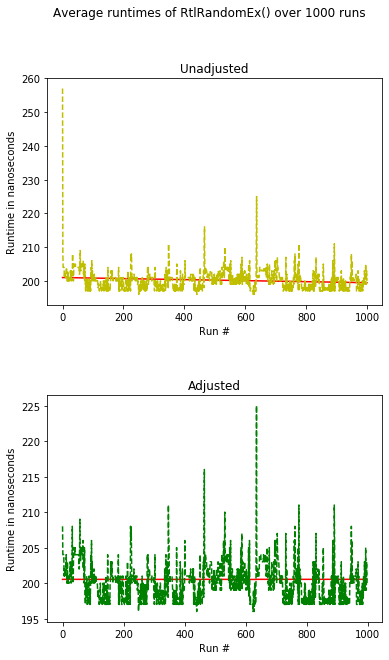

In [82]:
"""Section for RtlRandomEx()"""
fig, (orig,adj) = plt.subplots(2, gridspec_kw={'hspace':0.4})
fig.suptitle("Average runtimes of RtlRandomEx() over 1000 runs")
fig.set_figheight(10)

rtl_rand_data = np.loadtxt("singles_average_rtl.txt") #load our runtimes
rtl_values = np.loadtxt("rtl_all_values.txt") #load the random numbers
total_avg_rtl = np.average(rtl_rand_data) #find the overall average time of 
                                          #all runs

sr = pd.Series(rtl_values)
ct = sr.value_counts()
e_rtl = entropy(ct)


x = np.arange(len(rtl_rand_data))
y = rtl_rand_data

orig_slope, orig_intercept = np.polyfit(x, y, 1)
#print(slope,intercept)

slope_data = (x * orig_slope) + orig_intercept
orig.plot(x, slope_data, "-r", label="Best fit")

orig.plot(x,y,"y--", label='RtlRandomEx()')
orig.set_xlabel("Run #")
orig.set_ylabel("Runtime in nanoseconds")
orig.set_title("Unadjusted")

n = np.delete(y, 0, None)
x = np.arange(len(n))
adj_slope, adj_intercept = np.polyfit(x, n, 1)
#print(slope,intercept)

n_total_avg_rtl = np.average(n) #recalculate the overall average time

n_slope_data = (n * adj_slope) + adj_intercept
adj.plot(x, n_slope_data, "-r", label="Best fit")
adj.plot(x,n,"g--", label='adjusted RtlRandomEx()')
adj.set_title("Adjusted")
adj.set_xlabel("Run #")
adj.set_ylabel("Runtime in nanoseconds")
fig.show()

In [83]:
print("Shannon entropy for unadjusted RtlRandomEx():", e_rtl)
print("\tTime per unit entropy:", (total_avg_rtl/e_rtl), "ns")
print("\tModel: y = " + str(orig_slope) + " x+ " + str(orig_intercept))
print("Shannon enrtopy for adjusted RtlRandomEx():", n_e_rtl)
print("\tTime per unit entropy:", (n_total_avg_rtl/e_rtl), "ns")
print("\tModel: y = " + str(adj_slope) + " x+ " + str(adj_intercept))

Shannon entropy for unadjusted RtlRandomEx(): 16.1164704246988
	Time per unit entropy: 12.424060276444935 ns
	Model: y = -0.0015297855297854784 x+ 200.99612787212794
Shannon enrtopy for adjusted RtlRandomEx(): 16.11647032453602
	Time per unit entropy: 12.420534391227678 ns
	Model: y = -0.001192751870106574 x+ 200.77035835835832


## RtlRandomEx
As we see here, ```RtlRandomEx()``` and ```rand_s()``` have roughly the same amount of entropy, yet ```RtlRandomEx()``` is about $3ns$ faster on average. This is due to not having function overheads. (See Function Disassembly) The runtimes are ultimately stable with low deviation.

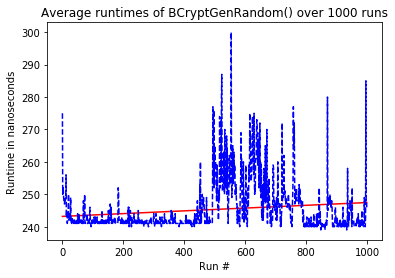

In [73]:
"""Section for BCryptGenRandom()"""

bcrypt_rand_data = np.loadtxt("singles_average_bcrypt.txt")
bcrypt_values = np.loadtxt("bcrypt_all_values.txt")
total_avg_bcrypt = np.average(bcrypt_rand_data);

sr = pd.Series(bcrypt_values)
ct = sr.value_counts()
e_bcrypt = entropy(ct)

x = np.arange(len(bcrypt_rand_data))
y = bcrypt_rand_data

slope, intercept = np.polyfit(x, y, 1)
#print(slope,intercept)

slope_data = (x * slope) + intercept
plt.plot(x, slope_data, "-r", label="Best fit")

rand_line = plt.plot(x,y,"b--", label='BCryptGenRandom()')
plt.xlabel("Run #")
plt.ylabel("Runtime in nanoseconds")
plt.title("Average runtimes of BCryptGenRandom() over 1000 runs")
plt.show()

In [74]:
print("Shannon entropy for BCryptGenRandom():", e_bcrypt)
print("\tTime per unit entropy:", (total_avg_bcrypt/e_bcrypt), "ns")
print("\tModel: y = " + str(slope) + " x+ " + str(intercept))

Shannon entropy for BCryptGenRandom(): 16.11648033805858
	Time per unit entropy: 15.221127371136086 ns
	Model: y = 0.004276414276414196 x+ 243.1749310689312


## BCryptGenRandom

To my surprise, ```BCryptGenRandom()``` also returned the same entropy for its dataset. This as well threw me off as the numbers in the dataset now also include negative numbers. Additionally, the runtime of ```BCryptGenRandom()``` is much closer to that of ```rand_s()```.

## Conclusion

There are some interesting conclusions to be made about the various RNG we've looked at here. The first thing we can conclude is that ```RtlRandomEx()```, ```BCryptGenRandom()```, and ```rand_s()``` must share the same entropy pool. This would make logical since as all of those functions are considered **secure** RNG, meaning that they wouldn't be sharing the same entropy pool as a **non-secure** function such as ```rand()```. With this hypothesis, we can give a pretty accurate rating of the analyzed RNG. Since ```rand()``` isn't FIPS approved, it will be excluded from the ratings of the rest. 

While some of the slope values are negative even after adjustment, that is due to the various factors discussed earlier which impact the runtimes of the functions. From a negative value, and even a very small positive value we can conclude that the entropy pool size plays no great role in the runtime of our functions. In functions such as ```BCryptGenRandom()``` this phenomenon is very apparent with an $m$ of .0042. As we can see, past 500 runs, the runtime becomes somewhat sporadic and also a lot longer. A similar phenomenon can be noted for ```rand()```, but the point at which it diverges is around 700 runs.

Overall, from the data gathered, a clear winner stands out: ```RtlRandomEx()```. In terms of entropy, it accesses the same pool as any other secure RNG on the OS. In terms of speed, it is fastest, by about $3ns$, out of all generators tested. This is most likely due to the fact that ```RtlRandomEx()``` directly calls to ```ExGenRandom()``` instead of having to pass through multiple OS layers and overheads in order to receive its output data (See Function Disassembly). Additionally, runtimes of ```RtlRandomEx()``` are generally within a $10ns$ range of each other as well, while others such as ```rand_s()``` run in a range of about $15ns$ to $20ns$.

## Function Disassembly
![Disassembly from IDA](img/rtl.png "RtlRandomEx() disassembly from IDA")

Source: ntoskrnl.exe@RtlRandomEx()

## References


  Howard, Michael., and David. LeBlanc. Writing Secure Code. 2nd ed. Sebastopol: Microsoft Press, 2004. 
  
  Lavavej, Stephan. "rand() Considered Harmful" Presentation, Going Native 2013, Redmond, WA, September 4-6, 2013. https://onedrive.live.com/view.aspx?resid=E66E02DC83EFB165!312&cid=e66e02dc83efb165&lor=shortUrl
  
  Niels Ferguson. 2019. "The Windows 10 random number generation infrastructure." Microsoft, November 25, https://download.microsoft.com/download/1/c/9/1c9813b8-089c-4fef-b2ad-ad80e79403ba/Whitepaper%20-%20The%20Windows%2010%20random%20number%20generation%20infrastructure.pdf. 
